# ObamaStarter

In this notebook, we will be building a predictive model to forecast the results of primary races in which Obama and Clinton both took part in the 2008 primary. We will use linear regression, regularized linear regression, and decision trees to forecast future primary results. We will also be interpreting these models in order to generate potentially useful insights for either the Obama or Clinton campaign to increase their chances of becoming the Democratic presidential nominee.

## Import Packages

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as smf

from patsy import dmatrices, dmatrix, build_design_matrices
import os
import math


In [3]:
os.getcwd()

'/home/jovyan/Data Analytics I/S08 and S11 - Clinton-Obama'

In [4]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load, Inspect, Clean, and Shape Data

We will load in our data set. However, this data set includes both past data and data on future primaries. The past data includes the candidates performance in the primaries that have already been completed. The primaries that are yet to be completed do not have this data.

In [5]:
elect_df = pd.read_csv("Obama.csv")

What are the columns of the dataset?

In [6]:
elect_df.columns

Index(['County', 'State', 'Region', 'FIPS', 'ElectionDate', 'ElectionType',
       'TotalVote', 'Clinton', 'Obama', 'MalesPer100Females', 'AgeBelow35',
       'Age35to65', 'Age65andAbove', 'White', 'Black', 'Asian',
       'AmericanIndian', 'Hawaiian', 'Hispanic', 'HighSchool', 'Bachelors',
       'Poverty', 'IncomeAbove75K', 'MedianIncome', 'AverageIncome',
       'UnemployRate', 'ManfEmploy', 'SpeakingNonEnglish', 'Medicare',
       'MedicareRate', 'SocialSecurity', 'SocialSecurityRate',
       'RetiredWorkers', 'Disabilities', 'DisabilitiesRate', 'Homeowner',
       'SameHouse1995and2000', 'Pop', 'PopDensity', 'LandArea', 'FarmArea'],
      dtype='object')

How many rows and columns do we have?

In [7]:
elect_df.shape

(2868, 41)

In [8]:
elect_df.head()

,County,State,Region,FIPS,ElectionDate,ElectionType,TotalVote,Clinton,Obama,MalesPer100Females,AgeBelow35,Age35to65,Age65andAbove,White,Black,Asian,AmericanIndian,Hawaiian,Hispanic,HighSchool,Bachelors,Poverty,IncomeAbove75K,MedianIncome,AverageIncome,UnemployRate,ManfEmploy,SpeakingNonEnglish,Medicare,MedicareRate,SocialSecurity,SocialSecurityRate,RetiredWorkers,Disabilities,DisabilitiesRate,Homeowner,SameHouse1995and2000,Pop,PopDensity,LandArea,FarmArea
0,Adair,IA,Midwest,19001,1/3/2008,Caucuses,75.0,22.0,24.0,96.7,37.7,40.3,21.9,99.2,0.1,0.5,NaN,0.0,0.8,87.8,11.2,9.7,8.6,39568.0,29222.0,3.2,12.916739,2.0,1551.0,19735.0,1825.0,23222.0,1230.0,90.0,1145.0,75.0,66.0,7714,13.5,570.0,373.0
1,Adams,IA,Midwest,19003,1/3/2008,Caucuses,50.0,18.0,7.0,96.8,37.1,40.8,22.1,99.2,NaN,0.2,0.5,0.0,0.6,84.5,12.0,10.6,7.8,35296.0,27297.0,4.6,6.964421,1.6,978.0,22936.0,1110.0,26032.0,720.0,78.0,1829.0,74.7,65.4,4192,9.9,425.0,238.0
2,Allamakee,IA,Midwest,19005,1/3/2008,Caucuses,80.0,25.0,33.0,104.5,41.5,40.8,17.7,99.0,0.2,0.2,0.3,0.0,6.9,81.4,14.4,10.8,10.7,36822.0,25579.0,4.6,16.473466,8.2,2838.0,19294.0,3270.0,22231.0,2245.0,186.0,1265.0,76.4,64.1,14796,23.1,659.0,326.0
3,Appanoose,IA,Midwest,19007,1/3/2008,Caucuses,60.0,17.0,10.0,94.0,42.0,39.2,18.9,98.5,0.7,0.4,0.1,0.0,1.1,81.4,12.2,14.9,6.6,31764.0,23705.0,5.4,15.080881,2.5,3072.0,22479.0,3415.0,24989.0,2050.0,453.0,3315.0,74.0,60.2,13422,27.0,516.0,236.0
4,Audubon,IA,Midwest,19009,1/3/2008,Caucuses,48.0,16.0,17.0,94.7,37.4,40.2,22.5,99.3,0.2,0.2,0.1,0.0,0.6,82.5,12.3,9.2,9.7,38941.0,31100.0,4.1,8.333333,2.7,1472.0,22797.0,1740.0,26947.0,1150.0,79.0,1223.0,79.2,70.4,6278,14.2,444.0,261.0


In [9]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

What are the names of the variables in the data frame? How many values are missing? Use our self defined `summarize_dataframe` function to find out the number of NA's for each variable.

In [10]:
summarize_dataframe(elect_df)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,,,,
County,object,0,1691,2868.0,1691,Washington,30,,,,,,,
State,object,0,46,2868.0,46,TX,251,,,,,,,
Region,object,0,4,2868.0,4,South,1419,,,,,,,
FIPS,int64,0,2868,2868.0,,,,31029,15411.4,1001,18102.5,30110,46123.5,56045
ElectionDate,object,0,18,2868.0,18,2/5/2008,1128,,,,,,,
ElectionType,object,0,2,2868.0,2,Primary,2558,,,,,,,
TotalVote,float64,1131,1490,1737.0,,,,12863.8,53071.9,13,732,2330,6418,1.41387e+06
Clinton,float64,1131,1338,1737.0,,,,5973.74,25402,4,329,1106,3200,771700
Obama,float64,1131,1314,1737.0,,,,6178.12,27477.2,4,254,878,2749,743686


We can see that we have some missing data. The missing data falls into two categories. First, we are missing data on `TotatVote`, `Clinton`, and `Obama`. These values are intended to be missing. They are data that we do not have yet, and this is what we will be trying to forecast. Often times, you will have two separate data sets, one that is intended for training that has all of the columns of data filled in and another for testing that is missing the prediction data. In this case, those two datasets are combined into one `.csv` file.

Let's deal with this combined data first. We will manually separate out the training and the testing sets.

## Creating Training and Testing Sets

We will create two separate data sets from the data in `elect_df`. We will create a _training_ data set and a _testing_ data set. The training data set will consist of elections that have already happened; the testing of those which are yet to come. In order to do this split, we need to be able to operate on _dates_.

The below code converts the `ElectionDate` column from just an arbitrary string (in the view of pandas) to something that means dates ordered in time.

In [11]:
elect_df["ElectionDate"] = pd.to_datetime(elect_df["ElectionDate"])

Once we have this, we can take all of the data before February 19, 2008 as our training set, and all of the data after that point as our testing set.

In [12]:
elect_df_train = elect_df[elect_df["ElectionDate"] < pd.to_datetime("2/19/2008")].copy()

In [13]:
elect_df_test = elect_df[elect_df["ElectionDate"] >= pd.to_datetime("2/19/2008")].copy()

Note that above we did something a little strange. We called `.copy()` on the pandas dataframe. Sometimes when we are creating new dataframes from existing dataframes, we can end up "linking" the two dataframes instead of creating a new dataframe. This can cause some weird issues. Specifically, we can change something in one dataframe, and it will actually change it in the other dataframe because in the background they are the same dataframe.

In order to avoid this, we are explicitly copying the dataframe. This tells python that we do not want these dataframes linked in the background. This often is not strictly necessary, but if you do not do this, it can lead to weird problems later on.

Now, we will create some possible dependent variables (things we might like to predict in a regression using the demographic information). These variables directly become a part of our data set `elect_df_train` dataframe.

In [14]:
elect_df_train["Obama_margin"] = elect_df_train["Obama"] - elect_df_train["Clinton"]
elect_df_train["Obama_margin_percent"] = elect_df_train["Obama_margin"] / elect_df_train["TotalVote"]
elect_df_train["Obama_wins"] = elect_df_train["Obama_margin"] > 0

Let's take a look and see that these variables are part of our dataframe now. You can also see that the "Data Type" of `ElectionDate` has changed. It is now a `datetime64[ns]` object because we told pandas that it is a date.

In [15]:
summarize_dataframe(elect_df_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  if __name__ == '__main__':


,Data Type,Missing Values,Unique Values,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,,,,,,
County,object,0,1138,1737.0,1138,Washington,19,,,,,,,,,
State,object,0,30,1737.0,30,GA,159,,,,,,,,,
Region,object,0,4,1737.0,4,South,811,,,,,,,,,
FIPS,int64,0,1737,1737.0,,,,,,25907.7,15270.2,1001,13157,25007,36095,53077
ElectionDate,datetime64[ns],0,9,1737.0,9,2008-02-05 00:00:00,1128,2008-01-03 00:00:00,2008-02-12 00:00:00,,,,,,,
ElectionType,object,0,2,1737.0,2,Primary,1454,,,,,,,,,
TotalVote,float64,0,1490,1737.0,,,,,,12863.8,53071.9,13,732,2330,6418,1.41387e+06
Clinton,float64,0,1338,1737.0,,,,,,5973.74,25402,4,329,1106,3200,771700
Obama,float64,0,1314,1737.0,,,,,,6178.12,27477.2,4,254,878,2749,743686


In [20]:
elect_df_train.to_csv("trainDF.csv")

Now we have a data set just of the previous primary elections (notice that we do not have any missing values for `Clinton`, `Obama`, or `TotalVote`).

## Split into `smaller_train` and `validation` Data Sets

However, we are not done yet manipulating our data. A best practice in machine learning is to further split up the training set into a smaller training set and a validation set. You can compare the performance of candidate models (each trained on the smaller training set) on the validation set. This `smaller_train` data set becomes our laboratory to test out different modeling decisions and try them out on the `validation` data set.

The following code randomly splits your training set into a smaller training set (75% of the training data) and a validation set (25% of the training data).

In [21]:
elect_df_smaller_train, elect_df_validation = train_test_split(elect_df_train, test_size=.25, random_state=201)

The test (or _validation_) data set is 25% of the original data. We also include the parameter `random_state=201` in the function call. This is because the function `train_test_split` randomly splits your data. This is good practice. However, if we let it randomly split our data, everytime we run our code something different will happen. We pass an initial _seed_ to the randomness generator in the function which makes the function give us _the same random split_ each time. This helps us with reproducibility with the code.

In our smaller training set, we now have 1302 data points. The other data is either in the test set or the validation set.

We also have missing data on a number of the numeric demographic data. However, even `ManfEmploy` which has the most missing data only has 133 missing data points out of a total of 1302 rows. Therefore, we probably don't want to just throw any of this data away.

We need to _impute_ the missing values. There are a number of possible strategies, but the most common is to just assume that the missing value is equal to the average of the non-missing values. This is, in some ways, a very safe assumption. If the data is missing just because someone forgot to input it, then there is no reason to believe that the data is either above or below average, so we should just assume it is average.

However, this strategy may not make sense with some data. Think about what else you might want to do.

To do the imputation, we will use an _object_ from the `sklearn` library called a _Transformer_. These transformers, unsurprisingly, transform data. We will see this pattern a lot when working with objects from `sklearn`, so it is worthwhile to understand how this thing works.

First, we create the `SimpleImputer` and we tell it what kind of imputer we would like it to be. Below, we create one called `imputer` and we tell it that missing values are `np.nan` (a common way for numpy and pandas to represent missing values) and we tell it to impute using the mean of existing data. Note that we don't actually give it the data yet.

In [22]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In order to impute anything, we need to `fit` the imputer. The imputer needs to know what the mean of all of the existing data is, so we give it the data set, and we let it learn the mean. After it has been fitted, we can use it to actually transform the data.

In [23]:
imputer.fit(elect_df_smaller_train.loc[:, "MalesPer100Females":"FarmArea"])

SimpleImputer()

Once we have `fit` the imputer (note that we fit all of the numeric rows at once, we don't need an imputer per column), we can then _transform_ the data.

In [24]:
elect_df_smaller_train.loc[:, "MalesPer100Females":"FarmArea"] = imputer.transform(elect_df_smaller_train.loc[:, "MalesPer100Females":"FarmArea"])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


You likely got a warning above. This is due to a bug in `train_test_split` not letting pandas know that things are a copy. You can ignore it. Note that this is not an error, and the code does run just fine.

Notice how we were able to fix all of the missing values at once with the syntax `.loc[:, "MalesPer100Females":"FarmArea"]`. This tells the dataframe that we want all columns between `MalesPer100Females` and `FarmArea`. If you check back at the dataframe summary you will see that these are all of our numeric columns, so it should be everything. You need to be careful when using this syntax because you don't want to accidentally include columns that you don't intend to. However, it can be a convenient way to get a bunch of columns without explicitly writing down all of the names.

Run the summary function again. Now you see that no demographic/county columns have NA entries.

In [25]:
summarize_dataframe(elect_df_smaller_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  if __name__ == '__main__':


,Data Type,Missing Values,Unique Values,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,,,,,,
County,object,0,921,1302.0,921,Franklin,15,,,,,,,,,
State,object,0,30,1302.0,30,GA,120,,,,,,,,,
Region,object,0,4,1302.0,4,South,608,,,,,,,,,
FIPS,int64,0,1302,1302.0,,,,,,25818.7,15254.1,1001,13163.5,24026,36086.5,53077
ElectionDate,datetime64[ns],0,9,1302.0,9,2008-02-05 00:00:00,836,2008-01-03 00:00:00,2008-02-12 00:00:00,,,,,,,
ElectionType,object,0,2,1302.0,2,Primary,1094,,,,,,,,,
TotalVote,float64,0,1137,1302.0,,,,,,13393,59063.2,13,692.75,2305,6417.25,1.41387e+06
Clinton,float64,0,1041,1302.0,,,,,,6143.65,28083.7,4,306.75,1080.5,3108.25,771700
Obama,float64,0,1048,1302.0,,,,,,6504.6,30755.1,4,249,864.5,2747,743686


The one thing you need to be careful of is that we haven't imputed values for our _validation_ or _test_ data yet. At this point, we could not use any model we built to predict on these other datasets because they will have missing values in them, so we need to impute the missing values for them as well. However, we need to be sure we use _the same imputer_ to impute data for those. I.e., we don't refit the imputer. Why is this so important? What might go wrong if we don't?

In [26]:
elect_df_validation.loc[:, "MalesPer100Females":"FarmArea"] = imputer.transform(elect_df_validation.loc[:, "MalesPer100Females":"FarmArea"])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Note that we have only imputed on our validation data set so far becuase at this stage of the process, our validation data set is a stand in for our testing data. We will impute on our testing data after we have chosen our models because at that point we will re-fit the imputer on the entire training data.

## Linear Regression

Now that our data set is fully prepared, we can fit our first model. We will first fit a linear regression model. We have seen this before with Casino Jack, but this time, we will use this model to predict the values in a new dataset.

In [27]:
lm_1 = smf.ols(formula='Obama_margin_percent ~ Region + Black + HighSchool + Poverty + PopDensity + SpeakingNonEnglish + LandArea', data=elect_df_smaller_train).fit()

In [28]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Obama_margin_percent   R-squared:                       0.604
Model:                              OLS   Adj. R-squared:                  0.601
Method:                   Least Squares   F-statistic:                     219.0
Date:                  Wed, 11 Nov 2020   Prob (F-statistic):          1.34e-252
Time:                          20:42:58   Log-Likelihood:                 322.05
No. Observations:                  1302   AIC:                            -624.1
Df Residuals:                      1292   BIC:                            -572.4
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.7635      0.104     -7.307      0.000      -0.968      -0.559
Region[T.Northeast]    -0.2002      0.022     -8.931      0.000      -0.244      -0.156
Region[T.South]        -0.1858      0.016    -11.810      0.000      -0.217      -0.155
Region[T.West]          0.1237      0.020      6.249      0.000       0.085       0.163
Black                   0.0184      0.000     39.197      0.000       0.017       0.019
HighSchool              0.0111      0.001     10.287      0.000       0.009       0.013
Poverty                -0.0186      0.002    -10.023      0.000      -0.022      -0.015
PopDensity          -6.003e-06   2.25e-06     -2.674      0.008   -1.04e-05    -1.6e-06
SpeakingNonEnglish      0.0004      0.001      0.536      0.592      -0.001       0.002
LandArea            -1.681e-06   4.25e-06     -0.396      0.693      -1e-05    6.66e-06
==============================================================================
Omnibus:                       18.291   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.290
Skew:                          -0.066   Prob(JB):                     2.65e-07
Kurtosis:                       3.735   Cond. No.                     5.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To evaluate the accuracy, we will use the self-defined `accuracy` function.

In [29]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)]})
    display(acc_df.style.hide_index())

Once a model has been trained, we need to actually predict over the new data set. We do that with the `.predict()` method.

In [30]:
lm_1_pred = lm_1.predict(elect_df_validation)

We can see our predictions.

In [31]:
lm_1_pred

1700   -0.356671
569    -0.411736
564     0.158380
538    -0.333613
992    -0.132063
          ...   
921     0.109874
1449   -0.129156
1062    0.048061
1172   -0.397628
111     0.071818
Length: 435, dtype: float64

Compare their accuracies on the validation set.

In [32]:
accuracy(elect_df_validation["Obama_margin_percent"], lm_1_pred)

RMSE,MAE,R^2
0.189380,0.144705,0.626595


## Regularized Regression Model

When variables are too closely correlated, linear regression has a problem estimating coefficients on the correlated variables. Consider the following example of multicollinearity between Medicare and Disabilities.

In [33]:
elect_df_smaller_train[["Medicare", "Disabilities"]].corr()

,Medicare,Disabilities
Medicare,1.000000,0.914991
Disabilities,0.914991,1.000000


Now train two models, one with Medicar and Disabilities and one with only Disabilities.

In [34]:
lm_with_mc = smf.ols(formula='Obama_margin_percent ~ Region + Black + HighSchool + Poverty + PopDensity + Medicare + Disabilities', data=elect_df_smaller_train).fit()
lm_with_mc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Obama_margin_percent   R-squared:                       0.612
Model:                              OLS   Adj. R-squared:                  0.610
Method:                   Least Squares   F-statistic:                     226.7
Date:                  Wed, 11 Nov 2020   Prob (F-statistic):          1.77e-258
Time:                          20:42:59   Log-Likelihood:                 335.74
No. Observations:                  1302   AIC:                            -651.5
Df Residuals:                      1292   BIC:                            -599.8
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.7776      0.102     -7.610      0.000      -0.978      -0.577
Region[T.Northeast]    -0.1775      0.022     -7.972      0.000      -0.221      -0.134
Region[T.South]        -0.1811      0.016    -11.577      0.000      -0.212      -0.150
Region[T.West]          0.1371      0.016      8.404      0.000       0.105       0.169
Black                   0.0186      0.000     40.129      0.000       0.018       0.020
HighSchool              0.0115      0.001     10.795      0.000       0.009       0.014
Poverty                -0.0194      0.002    -10.612      0.000      -0.023      -0.016
PopDensity          -3.906e-06   2.27e-06     -1.719      0.086   -8.36e-06    5.53e-07
Medicare            -1.179e-06   2.81e-07     -4.191      0.000   -1.73e-06   -6.27e-07
Disabilities         2.377e-06    9.5e-07      2.502      0.012    5.13e-07    4.24e-06
==============================================================================
Omnibus:                       22.097   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.462
Skew:                          -0.087   Prob(JB):                     4.45e-09
Kurtosis:                       3.824   Cond. No.                     1.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
lm_without_mc = smf.ols(formula='Obama_margin_percent ~ Region + Black + HighSchool + Poverty + PopDensity + Disabilities', data=elect_df_smaller_train).fit()
lm_without_mc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Obama_margin_percent   R-squared:                       0.607
Model:                              OLS   Adj. R-squared:                  0.605
Method:                   Least Squares   F-statistic:                     249.6
Date:                  Wed, 11 Nov 2020   Prob (F-statistic):          6.48e-256
Time:                          20:42:59   Log-Likelihood:                 326.95
No. Observations:                  1302   AIC:                            -635.9
Df Residuals:                      1293   BIC:                            -589.4
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.7431      0.103     -7.249      0.000      -0.944      -0.542
Region[T.Northeast]    -0.1957      0.022     -8.903      0.000      -0.239      -0.153
Region[T.South]        -0.1879      0.016    -11.995      0.000      -0.219      -0.157
Region[T.West]          0.1312      0.016      8.024      0.000       0.099       0.163
Black                   0.0185      0.000     39.687      0.000       0.018       0.019
HighSchool              0.0109      0.001     10.276      0.000       0.009       0.013
Poverty                -0.0188      0.002    -10.241      0.000      -0.022      -0.015
PopDensity          -2.822e-06   2.27e-06     -1.242      0.214   -7.28e-06    1.64e-06
Disabilities        -1.253e-06   3.93e-07     -3.186      0.001   -2.02e-06   -4.81e-07
==============================================================================
Omnibus:                       18.819   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.454
Skew:                          -0.068   Prob(JB):                     1.48e-07
Kurtosis:                       3.749   Cond. No.                     2.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

How did the first regression model above (with both Medicare and Disabilities in it) decide to put a negative weight on Medicare and a positive weight on Disabilities? In the second model, Disabilities (which contains almost the same information as Medicare) has a negative weight.

One way to avoid this multicollinearity problem is to make sure that you never pick variables that are too correlated. However, then you have to figure out what too correlated actually is, which will depend on the data set and whether or not there really is new information in each variable (Medicare and Disabilities are not 100% correlated!). This also is very difficult if you have lots of variables.

A different solution to multicollinearity and overfitting in general is regularization. It works by penalizing a regression for the size of its coefficients. The further away from 0 a coefficient is; the bigger the penalty. This penalty prevents a regression from overreacting to outliers and/or placing extreme weights on two correlated variables (i.e., one large negative coefficient and one large positive coefficient).

## LASSO Regression

The lasso, Least Absolute Shrinkage and Selection Operator, is a regularized regression model thats fits a linear regression by minimizing the usual sum of squared errors plus the complexity parameter (`alpha`) times the sum of the absolute values of the coefficients.  See ISL pp. 214-228.

However, for this model, we cannot use the same syntax that we used to come up with our dataset (it is an `sklearn` model, not a `statsmodel` model). So, we have to construct our dataset in a slightly different way. Moreover, if we don't have to worry about multi-collinearity, we might as well throw everything into our model, which would get quite tedious with the previous approach.

Luckily, there is a solution. We can use very similar syntax to explicitly create a dataframe for us with exactly the variables we want. We can still write out the equation in something like natural language, we just give it to the `dmatrices` function from `patsy`. You can dive deeper into how this syntax works at [this](https://patsy.readthedocs.io/en/latest/formulas.html#) link. However, we still have the problem of writing out the formula. We can get around this by using some clever python list comprehension and text manipulation.

Below we create a list of all the variables we want. We do this by looping through all of the columns in our training dataframe, and then added all columns that aren't in the list we don't want. The list we don't want includes some obvious things like `Clinton`, `Obama`, `TotalVote`, `Obama_margin_percent`, etc., i.e. things that we won't have in the testing data set. However, we also include `ElectionDate`, `State`, `County`, and `FIPS` in the things we want to throw out. Why?

In [36]:
variables = [variable for variable in elect_df_smaller_train.columns if variable not in ['FIPS', 'County', 'State', 'ElectionDate', 'TotalVote', 'Obama_margin', 'Obama_margin_percent', 'Obama_wins', 'Clinton', 'Obama']]

In [37]:
variables

['Region',
 'ElectionType',
 'MalesPer100Females',
 'AgeBelow35',
 'Age35to65',
 'Age65andAbove',
 'White',
 'Black',
 'Asian',
 'AmericanIndian',
 'Hawaiian',
 'Hispanic',
 'HighSchool',
 'Bachelors',
 'Poverty',
 'IncomeAbove75K',
 'MedianIncome',
 'AverageIncome',
 'UnemployRate',
 'ManfEmploy',
 'SpeakingNonEnglish',
 'Medicare',
 'MedicareRate',
 'SocialSecurity',
 'SocialSecurityRate',
 'RetiredWorkers',
 'Disabilities',
 'DisabilitiesRate',
 'Homeowner',
 'SameHouse1995and2000',
 'Pop',
 'PopDensity',
 'LandArea',
 'FarmArea']

Our variables are in two categories. The first two variables (`Region` and `ElectionType`) are categorical, and we want to make sure we dummy code those variables. The rest are all continuous. When we are using reguralized regression, since we penalize large regression coefficients, we need to make sure that every independent variable has roughly the same range. You should spend some time making sure that you understand and agree with this statement.

In order to both a) ensure that all of the continuous variables have the same range and b) consistently apply the transformation, we are going to make use of the `standardize()` function built into the `patsy` syntax in order to transform these variables into new variables that are mean `0` and have standard deviation of `1`. To do this we are going to have to get a little clever in how we set up our formula.

First, we are going to have to treat the first two variables separately. They are categorical variables, and it doesn't make sense to standardize them (you would also get an error). So, we will pull them out and add them to the formula using the `.join()` method of putting together strings in a list.

Then, we are going to need to do the same thing, but we are going to have to surround each variable with `standardize(VARIABLE_NAME)`. The below piece of code will construct our formula:

In [38]:
formula = 'Obama_margin_percent ~ ' + " + ".join(variables[:2]) +  " + standardize(" + ") + standardize(".join(variables[2:]) + ")"

We can then print the formula to make sure it did what we wanted.

In [39]:
print(formula)

Obama_margin_percent ~ Region + ElectionType + standardize(MalesPer100Females) + standardize(AgeBelow35) + standardize(Age35to65) + standardize(Age65andAbove) + standardize(White) + standardize(Black) + standardize(Asian) + standardize(AmericanIndian) + standardize(Hawaiian) + standardize(Hispanic) + standardize(HighSchool) + standardize(Bachelors) + standardize(Poverty) + standardize(IncomeAbove75K) + standardize(MedianIncome) + standardize(AverageIncome) + standardize(UnemployRate) + standardize(ManfEmploy) + standardize(SpeakingNonEnglish) + standardize(Medicare) + standardize(MedicareRate) + standardize(SocialSecurity) + standardize(SocialSecurityRate) + standardize(RetiredWorkers) + standardize(Disabilities) + standardize(DisabilitiesRate) + standardize(Homeowner) + standardize(SameHouse1995and2000) + standardize(Pop) + standardize(PopDensity) + standardize(LandArea) + standardize(FarmArea)


It did, so we can make our new dataframes. Note that you certainly could have just typed in the formula by hand, but that would have been tedious and prone to mistyping variable names. You can also include interaction variables by just modifying the above formula.

We can now use the formula to construct our "design matrices" or the matrices that will be used for the regressions. I will name them `X_linear` for the set of independent variables we are using in our linear models and `y_linear` for the y variables.

In [40]:
y_linear, X_linear = dmatrices(formula, elect_df_smaller_train, return_type="dataframe")

We can see what `X_linear` ended up with:

In [41]:
X_linear

,Intercept,Region[T.Northeast],Region[T.South],Region[T.West],ElectionType[T.Primary],standardize(MalesPer100Females),standardize(AgeBelow35),standardize(Age35to65),standardize(Age65andAbove),standardize(White),standardize(Black),standardize(Asian),standardize(AmericanIndian),standardize(Hawaiian),standardize(Hispanic),standardize(HighSchool),standardize(Bachelors),standardize(Poverty),standardize(IncomeAbove75K),standardize(MedianIncome),standardize(AverageIncome),standardize(UnemployRate),standardize(ManfEmploy),standardize(SpeakingNonEnglish),standardize(Medicare),standardize(MedicareRate),standardize(SocialSecurity),standardize(SocialSecurityRate),standardize(RetiredWorkers),standardize(Disabilities),standardize(DisabilitiesRate),standardize(Homeowner),standardize(SameHouse1995and2000),standardize(Pop),standardize(PopDensity),standardize(LandArea),standardize(FarmArea)
1677,1.0,0.0,1.0,0.0,1.0,-0.157112,-1.318521,1.972336,0.066582,0.507973,-0.383097,-0.420706,-2.926995e-01,-0.464422,-0.442051,-0.156514,0.706687,-1.399435,1.335998,1.116971,0.904296,-1.476117,-1.003939e+00,-0.520640,-0.294441,0.786197,-0.319977,0.091932,-0.308114,-0.197891,-0.768164,0.200764,1.088300,-0.265316,-0.137642,-0.507381,-0.567854
594,1.0,0.0,1.0,0.0,1.0,-0.469768,0.129313,-0.575092,0.315978,-1.652649,1.833249,-0.338955,-2.683932e-01,0.311801,-0.292414,-0.848317,0.075640,0.931367,0.517089,-0.340774,0.056417,0.777729,-4.664828e-01,-0.458838,-0.266044,0.292426,-0.277646,0.669039,-0.269523,-0.167923,0.498135,0.348283,-0.223162,-0.245378,-0.132594,-0.415350,-0.647284
642,1.0,0.0,1.0,0.0,1.0,0.301450,0.780837,-0.054027,-1.005819,0.077098,0.067792,-0.298079,-2.926995e-01,-0.464422,-0.488812,-0.238592,-0.352996,-0.615803,0.480961,0.718449,-0.243072,-0.036160,7.277537e-02,-0.530940,-0.281042,-0.657090,-0.296665,-0.674390,-0.287928,-0.185359,-0.513338,0.987531,-0.087959,-0.242346,-0.118266,-0.539161,-0.671724
1200,1.0,0.0,1.0,0.0,1.0,-0.303018,-0.124058,-0.140872,0.266099,-0.472424,-0.599017,-0.379830,3.426173e+00,-0.464422,-0.329823,-0.965571,-0.436341,0.509411,-0.843744,-1.038256,-0.794110,-0.223980,6.367941e-01,-0.479439,-0.284668,0.491214,-0.300079,0.895896,-0.297872,-0.174461,1.022246,0.040952,-0.209641,-0.257579,-0.141836,-0.248503,0.189785
81,1.0,0.0,0.0,0.0,0.0,-0.271753,0.147410,0.553882,-0.681605,0.289413,-0.332293,0.233303,-2.683932e-01,-0.464422,-0.198891,1.051210,0.944818,-0.254127,0.721817,0.817015,1.059824,-0.537014,2.315412e-01,-0.252830,0.142947,-0.554308,0.168485,-0.702974,0.173526,0.005620,-0.401889,-0.364724,-0.547647,0.106632,-0.010239,-0.374300,-0.106550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,1.0,0.0,0.0,0.0,0.0,0.009637,-0.305037,-0.488248,0.864648,0.826447,-0.700626,-0.338955,-2.683932e-01,-0.464422,-0.535574,0.969131,0.039920,-1.218597,-0.109135,0.251347,0.377368,-0.537014,1.518093e-01,-0.500039,-0.177964,0.645200,-0.187717,0.715538,-0.169930,-0.172418,-0.751296,0.446629,0.358208,-0.197674,-0.126420,-0.207453,0.027870
1377,1.0,0.0,1.0,0.0,1.0,0.478621,0.328390,-0.343508,-0.157874,-0.228886,0.398022,-0.420706,-2.440868e-01,-0.464422,-0.470107,-1.399414,-0.972136,1.413602,-0.771487,-0.716467,-0.886786,-0.537014,-1.081186e+00,-0.489739,-0.288049,0.090061,-0.309150,-0.131705,-0.308411,-0.172350,1.124659,0.692494,0.331168,-0.257150,-0.140322,-0.325968,-0.619789
1536,1.0,0.0,0.0,1.0,1.0,0.624527,1.540950,-1.472482,-0.831242,0.614131,-0.656172,-0.052826,-1.023222e-03,0.311801,2.541333,-0.602082,-0.388715,0.529505,-0.169349,-0.112206,-0.679415,1.215976,-1.393121e-01,2.085355,-0.099575,-0.668009,-0.103056,-0.895611,-0.097944,-0.086192,-0.268753,-0.844161,-1.088456,-0.084846,-0.136167,1.163740,2.474923
1577,1.0,1.0,0.0,0.0,0.0,-0.375971,-1.101346,0.930206,0.739950,0.532952,-0.700626,-0.338955,7.767803e-01,-0.464422,-0.516869,0.300779,-0.269650,0.770622,-0.807616,-0.919035,-0.323205,1.716831,-2.164124e-01,-0.273431,-0.172555,0.98

As you can see, there is an `Intercept` column (of all one's), a set of columns dummy encoding the region and election type, and columns that correspond to the standardized variables we put in.

`y_linear` is just the Obama percent margin.

In [42]:
y_linear

,Obama_margin_percent
1677,0.199231
594,0.399012
642,-0.020424
1200,-0.386296
81,0.188571
...,...
868,0.047990
1377,-0.142698
1536,-0.085749
1577,0.272727


Now we have to start building our Lasso model. We start with getting a `Lasso` object set up with all of the parameters. We choose `alpha`, which is our regularization parameter, and we choose `max_iter` which is a parameter that just tells the model how long it can train for (you don't need to worry about the details here right now).

In [43]:
lm_lasso = Lasso(alpha = 1, max_iter=1000000)

Once we have our lasso object, we can fit it to our data. This is just like the imputer we used above.

In [44]:
lm_lasso.fit(X_linear, y_linear)

Lasso(alpha=1, max_iter=1000000)

In order to predict on our validation data, we have to convert our validation data into the same format as our training data (using the exact same transformations and dummy codings). We can do that with the `build_design_matrices` function from `patsy`. We give it the `design_info` of our earlier dataframe `X_linear`, and we give it our new data. Note that at the end we access it with `[0]`. This is because it returns a list of dataframes (though the list only has one element in it), so we ask for the first element in that list.

In [45]:
X_validation_linear = build_design_matrices([X_linear.design_info], elect_df_validation, return_type="dataframe")[0]

We can see it worked!

In [46]:
X_validation_linear

,Intercept,Region[T.Northeast],Region[T.South],Region[T.West],ElectionType[T.Primary],standardize(MalesPer100Females),standardize(AgeBelow35),standardize(Age35to65),standardize(Age65andAbove),standardize(White),standardize(Black),standardize(Asian),standardize(AmericanIndian),standardize(Hawaiian),standardize(Hispanic),standardize(HighSchool),standardize(Bachelors),standardize(Poverty),standardize(IncomeAbove75K),standardize(MedianIncome),standardize(AverageIncome),standardize(UnemployRate),standardize(ManfEmploy),standardize(SpeakingNonEnglish),standardize(Medicare),standardize(MedicareRate),standardize(SocialSecurity),standardize(SocialSecurityRate),standardize(RetiredWorkers),standardize(Disabilities),standardize(DisabilitiesRate),standardize(Homeowner),standardize(SameHouse1995and2000),standardize(Pop),standardize(PopDensity),standardize(LandArea),standardize(FarmArea)
1700,1.0,0.0,1.0,0.0,1.0,-1.751657,-0.775583,-0.748781,1.712594,0.451772,-0.351345,-0.216328,-0.292700,-0.464422,-0.498164,-0.578631,0.004201,0.650063,-0.663102,-0.872107,6.560254e-17,0.026447,-2.238674e-16,-0.572142,-0.208615,3.002425,-0.254335,1.612499,-0.254532,-0.147626,1.339122,-1.040852,0.033723,-0.240683,0.378534,-0.675552,7.317654e-17
569,1.0,0.0,1.0,0.0,1.0,-0.219644,0.545565,-0.198768,-0.556907,0.764001,-0.649821,-0.338955,-0.244087,-0.464422,-0.516869,-1.211806,-0.722098,-0.254127,-0.277734,-0.130234,-5.917561e-01,-0.411801,1.029992e+00,-0.489739,-0.271412,-0.091409,-0.289448,-0.191690,-0.288967,-0.179365,-0.177184,0.827719,0.236526,-0.243705,-0.111898,-0.568955,-7.206043e-01
564,1.0,0.0,1.0,0.0,1.0,-0.396815,0.563662,0.727570,-1.429792,-0.278843,0.163051,0.887312,-0.268393,0.311801,-0.348528,1.238817,1.790182,-1.359248,2.034479,2.232996,1.102469e+00,-0.349194,-3.679372e-01,0.014979,-0.102812,-1.254397,-0.090279,-1.448161,-0.095866,-0.132983,-0.947085,1.048997,-0.642289,-0.026751,-0.004997,-0.480235,-7.358793e-01
538,1.0,0.0,1.0,0.0,1.0,-0.250909,0.509369,-0.372456,-0.407270,0.164522,-0.027466,-0.338955,-0.292700,-0.464422,-0.357880,-1.329061,-0.900697,0.730436,-0.663102,-0.550771,-4.975473e-01,-0.286587,2.290338e+00,-0.417636,-0.269015,-0.085009,-0.284083,-0.013344,-0.284069,-0.158524,0.871037,0.225351,0.250046,-0.242454,-0.133759,-0.380921,-4.212146e-01
992,1.0,0.0,0.0,0.0,1.0,-0.980439,-0.666996,-0.285612,1.163923,0.801468,-0.675223,-0.420706,-0.244087,-0.464422,-0.535574,0.312505,-0.734005,0.208015,-0.891915,-0.733861,-4.561568e-01,1.278583,5.348668e-01,-0.489739,-0.264077,1.116946,-0.287985,0.770491,-0.279171,-0.184065,-0.188630,0.409749,0.114844,-0.251765,-0.140089,-0.273000,2.325549e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,1.0,0.0,0.0,0.0,0.0,-0.063316,0.346487,0.003869,-0.457149,0.689066,-0.586315,-0.175452,-0.317006,-0.464422,-0.208243,1.086386,0.373304,-1.319062,0.468918,1.035527,5.894768e-01,-0.411801,1.902549e+00,-0.108625,-0.219289,-0.483715,-0.235022,-0.731558,-0.219504,-0.181817,-0.997689,0.803133,-0.074439,-0.195870,-0.115392,-0.398136,5.536504e-02
1449,1.0,0.0,0.0,0.0,1.0,0.916339,0.183606,-0.922469,0.540434,0.807713,-0.719677,-0.379830,-0.244087,4.969139,2.354287,-0.625533,-0.650659,-0.816734,-0.386118,-0.014546,-7.360792e-02,-1.476117,-2.238674e-16,2.116256,-0.250657,3.424285,-0.315880,-0.748869,-0.306184,-0.199662,-1.157332,0.200764,0.439329,-0.258352,-0.138613,-0.406743,-6.072486e-02
1062,1.0,1.0,0.0,0.0,1.0,-0.428081,-0.305037,1.161791,-0.581847,0.033386,-0.211632,1.500445,-0.292700,-0.464422,0.091030,1.238817,2.099752,-1.540086,3.347141,3.113840,2.939539e+00,-0.349194,-1.021779e+00,0.684504,1.535019,-0.542825,1.608121,-0.843678,1.690726,0.259327,-0.910337,0.127005,0.412289,1.237815,0.374573,-0.243868,-6.625594e-01
1172,1.0,0.0,1.0,0.0,1.0,-0.230065,0.527467,-0.806677,-0.033176,-0.241375,-0.624419,-0.257204,2.648370,-0.464422,-0.273709,-0.285494,0.111360,0.609877,-0.747402,-0.970130,-4.288418e-01,-0.662228,-4

Now let's predict on our new dataset.

In [47]:
lm_lass_pred = lm_lasso.predict(X_validation_linear)

How did we do?

In [48]:
accuracy(lm_lass_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.311966,0.254121,-8085241931389026900314719128649728.000000


Eh, not too well. Maybe we chose the wrong `alpha`. Let's take a closer look at what `alpha` is actually doing. We are going to try a bunch of different `alpha`s and see how the regression coefficients change as we change the `alpha`s. The details of what are happening in the next few cells are not important. The graph that comes out is.

The first thing we're going to do is get a list of `alpha`s to try. The below code will give us a list of `alpha` that range from `1*10^-5` to `1`.

In [49]:
alphas = np.logspace(-5,0, 20)

In [50]:
alphas

array([1.00000000e-05, 1.83298071e-05, 3.35981829e-05, 6.15848211e-05,
       1.12883789e-04, 2.06913808e-04, 3.79269019e-04, 6.95192796e-04,
       1.27427499e-03, 2.33572147e-03, 4.28133240e-03, 7.84759970e-03,
       1.43844989e-02, 2.63665090e-02, 4.83293024e-02, 8.85866790e-02,
       1.62377674e-01, 2.97635144e-01, 5.45559478e-01, 1.00000000e+00])

Now we will build models using each of those alphas using this loop.

In [51]:
%%time
coefs = []
for a in alphas:
    lm_lasso = Lasso(alpha=a, max_iter=1000000)
    lm_lasso.fit(X_linear, y_linear)
    coefs.append(lm_lasso.coef_)

CPU times: user 1.95 s, sys: 1.49 s, total: 3.44 s
Wall time: 1.7 s


Finally, we will plot the coefficients for the independent variables from each of our models as the `alpha` changes.

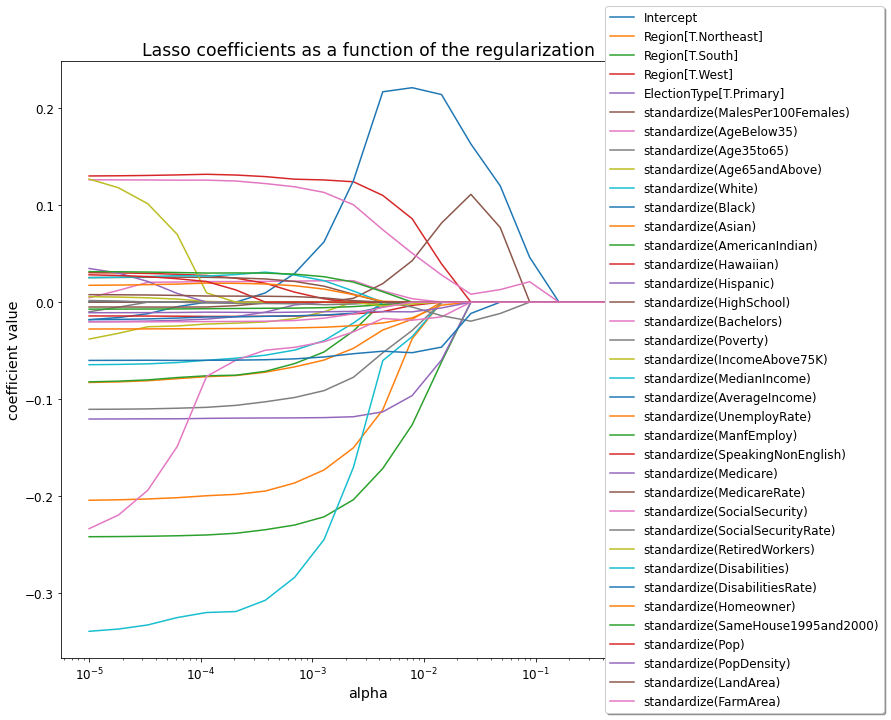

In [52]:
ax = plt.gca()

for i in range(len(coefs[0])):
    ax.plot(alphas, [coef[i] for coef in coefs], label=X_linear.columns[i])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficient value')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(loc='right', bbox_to_anchor=(1.35, 0.5), shadow=True, ncol=1)
plt.show()

As we increase `alpha`, the variables are "turning off". The higher the `alpha`, the fewer the variables are that have a non-zero regression coefficient. It is trying to find only the most impactful variables.

The question naturally arises, how does one actually choose the `alpha` here. We do this with out of sample testing! However, plugging and chugging through a bunch of `alpha` values is boring, and we want to let the computer do the boring work. Moreover, there is something better than just out of sample testing.

If our training set is small, a regression model's performance will be sensitive to the rows we (randomly) chose to put in the one validation set. To combat this sensitivity, statisticians employ a technique called K-fold cross-validation. They often use 5-fold cross-validation. See ISL pp. 175-184 for more information on this topic. 

Suppose we use 5-fold cross-validation to find the best setting for the parameter lambda in the lasso. Below are the steps in the procedure.

Step 1: Split the training set randomly up into 5 equal "folds": Fold 1, Fold 2, Fold 3, Fold 4, and Fold 5.

Step 2: Use Folds 1, 2, 3, and 4 as the smaller training set and Fold 5 as the validation set. For each level of the model's parameter, record the average prediction errors on the Fold 5 validation set.

Step 3: Use Folds 1, 2, 3, and 5 as the smaller training set and Fold 4 as the validation set. For each level of the model's parameter, record the average prediction errors on the Fold 4 validation set.

Step 4: Use Folds 1, 2, 4, and 5 as the smaller training set and Fold 3 as the validation set. For each level of the model's parameter, record the average prediction errors on the Fold 3 validation set.

Step 5: Use Folds 1, 3, 4, and 5 as the smaller training set and Fold 2 as the validation set. For each level of the model's parameter, record the average prediction errors on the Fold 2 validation set.

Step 6: Use Folds 2, 3, 4, and 5 as the smaller training set and Fold 1 as the validation set. For each level of the model's parameter, record the average prediction errors on the Fold 1 validation set.

Step 7: For each level of the model's parameter, average the five folds' average prediction errors for each level of the model's tuning parameter. Select the tuning parameter level with the lowest overall average. 

It would be a giant pain to do all of this manually, so instead, we will use a very useful function called `GridSearchCV`. This automatically tries a bunch of parameter values (`alpha` in this case), and it runs 4-fold validation on it. Below we set it up with a Lasso model, and we give it the list of `alpha`s we looped through above.

Running `fit` on this might take a little bit of time (up to 10 minutes).

In [53]:
gs_lasso = GridSearchCV(Lasso(max_iter=1000000), {"alpha": alphas}, scoring='neg_mean_squared_error', cv=4)

In [54]:
%%time
gs_lasso.fit(X_linear, y_linear)

CPU times: user 9.19 s, sys: 7.73 s, total: 16.9 s
Wall time: 8.44 s


GridSearchCV(cv=4, estimator=Lasso(max_iter=1000000),
             param_grid={'alpha': array([1.00000000e-05, 1.83298071e-05, 3.35981829e-05, 6.15848211e-05,
       1.12883789e-04, 2.06913808e-04, 3.79269019e-04, 6.95192796e-04,
       1.27427499e-03, 2.33572147e-03, 4.28133240e-03, 7.84759970e-03,
       1.43844989e-02, 2.63665090e-02, 4.83293024e-02, 8.85866790e-02,
       1.62377674e-01, 2.97635144e-01, 5.45559478e-01, 1.00000000e+00])},
             scoring='neg_mean_squared_error')

What is the best `alpha`?

In [55]:
gs_lasso.best_params_['alpha']

0.0006951927961775605

Let's put this on our plot.

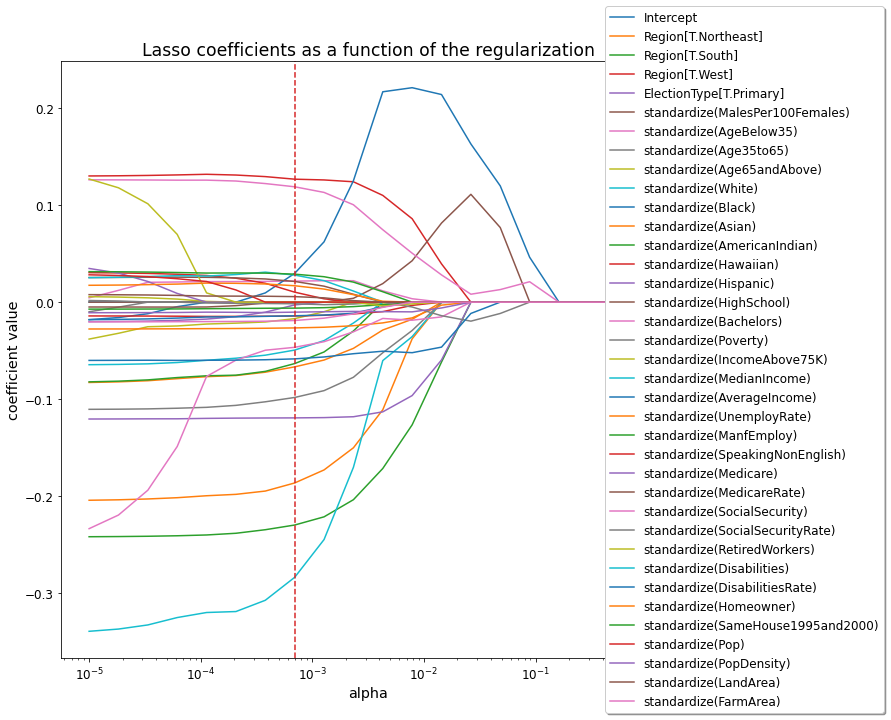

In [56]:
ax = plt.gca()

for i in range(len(coefs[0])):
    ax.plot(alphas, [coef[i] for coef in coefs], label=X_linear.columns[i])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficient value')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(loc='right', bbox_to_anchor=(1.35, 0.5), shadow=True, ncol=1)
plt.axvline(x=gs_lasso.best_params_['alpha'], linestyle='--', color='tab:red')
plt.show()

Our initial guess of `alpha = 1` was way off! Let's see how the optimal `alpha` does. By building our model again with the optimal `alpha`.

In [57]:
lm_lasso_optimized = Lasso(alpha = gs_lasso.best_params_['alpha'], max_iter=1000000)
lm_lasso_optimized.fit(X_linear,y_linear)

Lasso(alpha=0.0006951927961775605, max_iter=1000000)

Make a prediction using the regularized linear regression with an optimal lambda.

In [58]:
lm_lasso_optimized_pred = lm_lasso_optimized.predict(X_validation_linear)

Note that we could have also called `predict` straight on the `GridSearchCV` object, and it will automatically predict with the best model it found like so.

In [59]:
gs_lasso_pred = gs_lasso.predict(X_validation_linear)

In [60]:
print("Accuracy of the lm_lasso_optimized model:")
accuracy(lm_lasso_optimized_pred, elect_df_validation["Obama_margin_percent"])
print("Accuracy of the gs_lasso model:")
accuracy(gs_lasso_pred, elect_df_validation["Obama_margin_percent"])

Accuracy of the lm_lasso_optimized model:


RMSE,MAE,R^2
0.169306,0.127108,0.573883


Accuracy of the gs_lasso model:


RMSE,MAE,R^2
0.169306,0.127108,0.573883


That's better! Also, we see that both ways of predicting give us the exact same outcome, so they are both valid ways to do the final prediction.

There is one more thing we can do; we can look at the coefficients to tell us what variables are the most important. Since we standardized all of the variables, then what a coefficient means is exactly how much does the dependent variable `Obama_margin_percent` change for one standard deviation change in the independent variable. The independent variable with the highest coefficient means it has the highest impact on the predicted `Obama_margin_percent`. Note that it is the _absolute value of the coefficient_ not the size directly. A very negative coefficient is just as meaningful as a very postive coefficient (though obviously it affects the dependent variable in the opposite way).

This next piece of code will plot the coefficients.

In [61]:
def get_linear_importances(model, data):
    # This section is to handle both LASSO and ridge.
    if len(model.coef_) == 1:
        coefficients = np.concatenate((model.coef_[0], [model.intercept_]))
    else:
        coefficients = np.concatenate((model.coef_, model.intercept_))
    coef_df = pd.DataFrame({'Importance': coefficients}, index=data.columns.append(pd.Index(["Model Intercept"])))
    return coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

In [62]:
get_linear_importances(lm_lasso_optimized, X_linear)

,Importance
standardize(White),-0.283402
Region[T.South],-0.229548
Region[T.Northeast],-0.186221
Model Intercept,0.171247
Region[T.West],0.126629
ElectionType[T.Primary],-0.119207
standardize(Bachelors),0.118796
standardize(Poverty),-0.098177
standardize(Asian),-0.066662
standardize(AmericanIndian),-0.063282


The above is consistent with the size of the coefficients that we saw from our plot, but it gives us a very clear way to understand what factors are important for predicting an Obama victory. Note that we see the intercept in their twice. This is because our model has an intercept column, and the LASSO automatically fits an intercept. Since the intercept column in our model is redundant, the LASSO gets rid of it by setting the coefficient to `0`.

## Ridge Regression

Now let's try a ridge regression. This is another regularized regression techique, and we will use nearly the exact same code as before. Here, we will use the same `X_linear`, `y_linear`, and `X_validation_linear` that we used above. We certainly could have chosen different variables for this model as well, though.

In [63]:
alphas = np.logspace(-2,6, 20)

In [64]:
alphas

array([1.00000000e-02, 2.63665090e-02, 6.95192796e-02, 1.83298071e-01,
       4.83293024e-01, 1.27427499e+00, 3.35981829e+00, 8.85866790e+00,
       2.33572147e+01, 6.15848211e+01, 1.62377674e+02, 4.28133240e+02,
       1.12883789e+03, 2.97635144e+03, 7.84759970e+03, 2.06913808e+04,
       5.45559478e+04, 1.43844989e+05, 3.79269019e+05, 1.00000000e+06])

You might get a few warnings below. Ignore them.

In [65]:
%%time
coefs = []
for a in alphas:
    lm_ridge = Ridge(alpha=a, fit_intercept=False, max_iter=1000000)
    lm_ridge.fit(X_linear, y_linear)
    coefs.append(lm_ridge.coef_[0])

CPU times: user 180 ms, sys: 197 ms, total: 377 ms
Wall time: 116 ms


In [66]:
gs_ridge = GridSearchCV(Ridge(fit_intercept=False, max_iter=1000000), {"alpha": alphas}, scoring='neg_mean_squared_error', cv=5)

In [67]:
%%time
gs_ridge.fit(X_linear, y_linear)

CPU times: user 2.53 s, sys: 2.1 s, total: 4.64 s
Wall time: 2.27 s


GridSearchCV(cv=5, estimator=Ridge(fit_intercept=False, max_iter=1000000),
             param_grid={'alpha': array([1.00000000e-02, 2.63665090e-02, 6.95192796e-02, 1.83298071e-01,
       4.83293024e-01, 1.27427499e+00, 3.35981829e+00, 8.85866790e+00,
       2.33572147e+01, 6.15848211e+01, 1.62377674e+02, 4.28133240e+02,
       1.12883789e+03, 2.97635144e+03, 7.84759970e+03, 2.06913808e+04,
       5.45559478e+04, 1.43844989e+05, 3.79269019e+05, 1.00000000e+06])},
             scoring='neg_mean_squared_error')

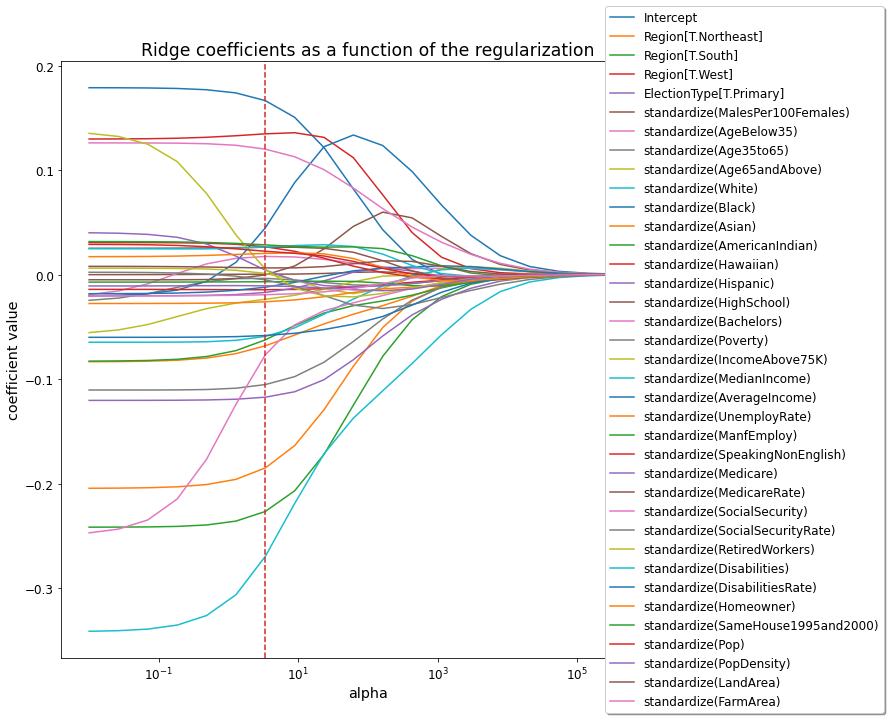

In [68]:
ax = plt.gca()


for i in range(len(coefs[0])):
    ax.plot(alphas, [coef[i] for coef in coefs], label=X_linear.columns[i])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficient value')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(loc='right', bbox_to_anchor=(1.35, 0.5), shadow=True, ncol=1)
plt.axvline(x=gs_ridge.best_params_['alpha'], linestyle='--', color='tab:red')
plt.show()

The way that the ridge regression regularizes is a little different. What do you think are the advantages/disadvantages between the ridge regression and the Lasso?

In [69]:
gs_ridge_pred = gs_ridge.predict(X_validation_linear)

In [70]:
accuracy(gs_ridge_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.169032,0.126408,0.582412


Now we can look at the coefficients, but if we want to use our `gs_ridge` model directly, we have to get out the actual best model that it found. We can do that by looking at the value `gs_ridge.best_estimator_`.

In [71]:
get_linear_importances(gs_ridge.best_estimator_, X_linear)

,Importance
standardize(White),-0.269748
Region[T.South],-0.226760
Region[T.Northeast],-0.185098
Intercept,0.166505
Region[T.West],0.134695
standardize(Bachelors),0.120053
ElectionType[T.Primary],-0.117385
standardize(Poverty),-0.105318
standardize(SocialSecurity),-0.076810
standardize(Asian),-0.068213


## Regression Tree models

Read ISL pp. 303-311. These pages introduce regression trees. A regression tree is a way to fit a non-linear model to your data. It recursively subdivides your data into rectangular partitions and takes the average of the y-values in each partition as its prediction. Pay particular attention to Figure 8.3 in ISL. 

Here again, we can build a dataframe for the particular variables that we want to include. Note that we do not standardize the variables. Why? Should we?

In [72]:
y_tree, X_tree = dmatrices('Obama_margin_percent ~ 0 + Region + Black + HighSchool + Poverty + PopDensity + SpeakingNonEnglish + LandArea', elect_df_smaller_train, return_type="dataframe")

Note that we have a `0 + ` in the above formula. This tells `patsy` to not create an intercept column. Intercepts aren't useful for tree based models (why?). We can see what it created:

In [73]:
X_tree

,Region[Midwest],Region[Northeast],Region[South],Region[West],Black,HighSchool,Poverty,PopDensity,SpeakingNonEnglish,LandArea
1677,0.0,0.0,1.0,0.0,5.4,76.0,6.6,27.0,3.0,267.0
594,0.0,0.0,1.0,0.0,40.3,70.1,18.2,40.0,3.6,406.0
642,0.0,0.0,1.0,0.0,12.5,75.3,10.5,76.9,2.9,219.0
1200,0.0,0.0,1.0,0.0,2.0,69.1,16.1,16.2,3.4,658.0
81,1.0,0.0,0.0,0.0,6.2,86.3,12.3,355.1,5.6,468.0
...,...,...,...,...,...,...,...,...,...,...
868,1.0,0.0,0.0,0.0,0.4,85.6,7.5,55.9,3.2,720.0
1377,0.0,0.0,1.0,0.0,17.7,65.4,20.6,20.1,3.3,541.0
1536,0.0,0.0,0.0,1.0,1.1,72.2,16.2,30.8,28.3,2791.0
1577,0.0,1.0,0.0,0.0,0.4,79.9,17.4,13.0,5.4,3255.0


In [74]:
y_tree

,Obama_margin_percent
1677,0.199231
594,0.399012
642,-0.020424
1200,-0.386296
81,0.188571
...,...
868,0.047990
1377,-0.142698
1536,-0.085749
1577,0.272727


Just like before, we create our `DecisionTreeRegressor` object. In the below, we just use the default values for all of the parameters.

In [75]:
dt = DecisionTreeRegressor()

We fit it to the data.

In [76]:
dt.fit(X_tree,y_tree)

DecisionTreeRegressor()

Now we can plot it to see what kind of decisions it made.

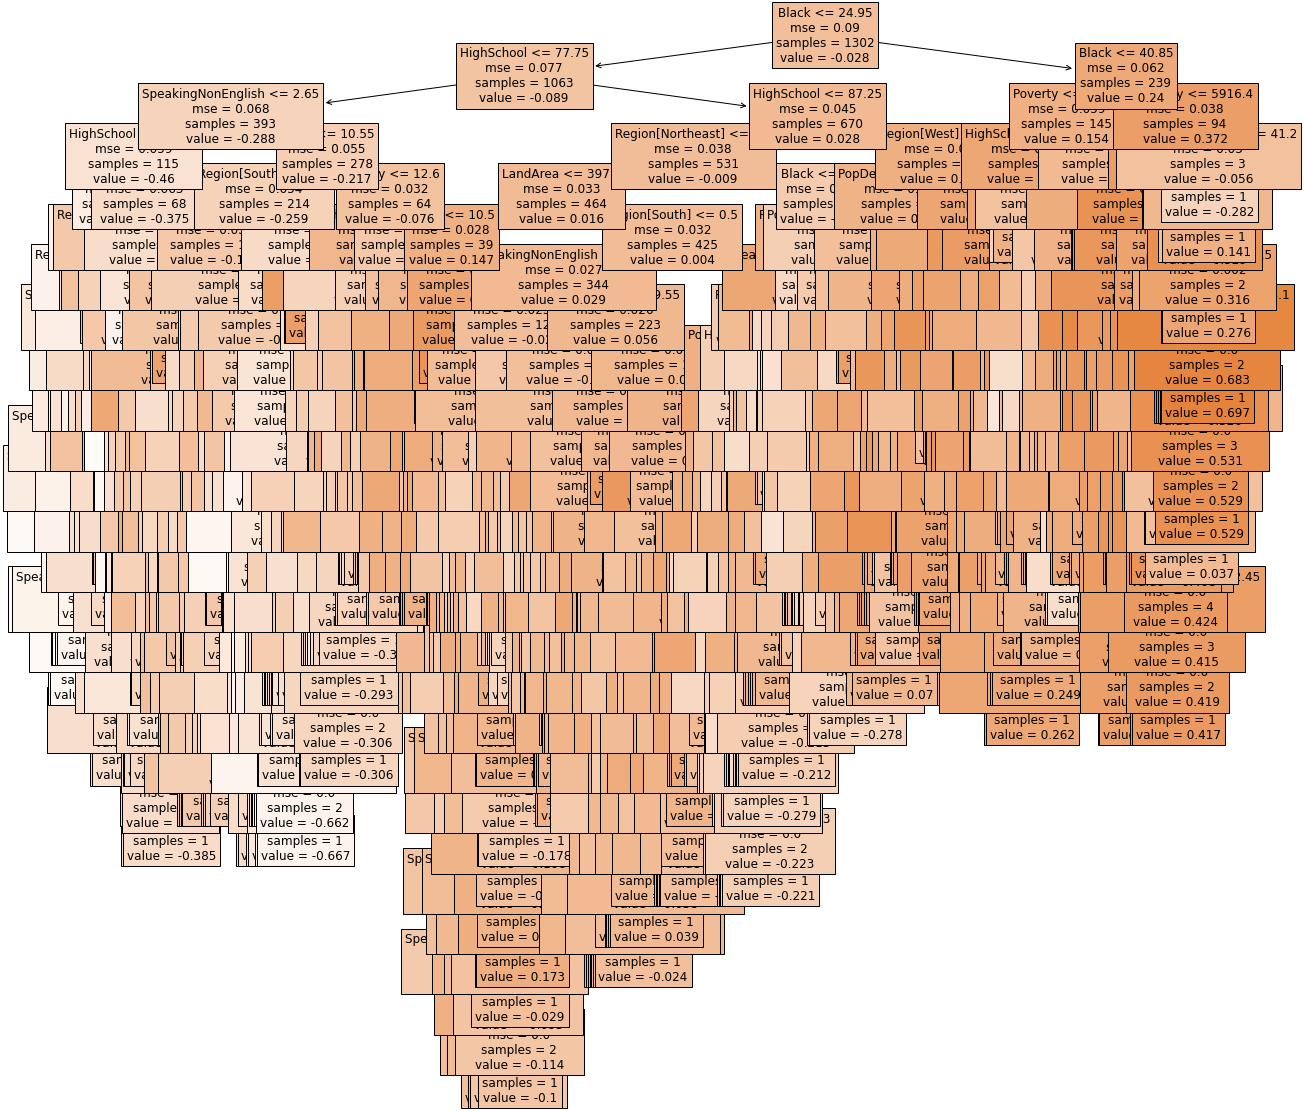

In [77]:
plt.figure(figsize=(20,20))
plot_tree(dt, feature_names=X_tree.columns, filled=True, fontsize=12)
plt.show()

Well, that plot is a little hard to interpret. It seems like we might have too many splits. Let's take a look at the models performance.

Let's build our validation data like we've done before (remember we changed how we made the data for this model).

In [78]:
X_validation_tree = build_design_matrices([X_tree.design_info], elect_df_validation, return_type="dataframe")[0]

In [79]:
X_validation_tree

,Region[Midwest],Region[Northeast],Region[South],Region[West],Black,HighSchool,Poverty,PopDensity,SpeakingNonEnglish,LandArea
1700,0.0,0.0,1.0,0.0,5.9,72.4,16.8,1356.3,2.5,13.0
569,0.0,0.0,1.0,0.0,1.2,67.0,12.3,93.3,3.3,174.0
564,0.0,0.0,1.0,0.0,14.0,87.9,6.8,368.6,8.2,308.0
538,0.0,0.0,1.0,0.0,11.0,66.0,17.2,37.0,4.0,458.0
992,1.0,0.0,0.0,0.0,0.8,80.0,14.6,20.7,3.3,621.0
...,...,...,...,...,...,...,...,...,...,...
921,1.0,0.0,0.0,0.0,2.2,86.6,7.0,84.3,7.0,432.0
1449,1.0,0.0,0.0,0.0,0.1,72.0,9.5,24.5,28.6,419.0
1062,0.0,1.0,0.0,0.0,8.1,87.9,5.9,1346.1,14.7,665.0
1172,0.0,0.0,1.0,0.0,1.6,74.9,16.6,42.2,3.5,943.0


Now we can predict on our validation set.

In [80]:
dt_pred = dt.predict(X_validation_tree)

In [81]:
accuracy(dt_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.224863,0.168529,0.475633


That is not great, but it's also a completely untuned decision tree. We can also look at the importance of various features using the below function.

In [82]:
def get_tree_importances(model, data):
    return pd.DataFrame({'Importance': model.feature_importances_}, index=data.columns).sort_values(['Importance'], ascending=False)

In [83]:
get_tree_importances(dt, X_tree)

,Importance
HighSchool,0.303133
Black,0.300032
Poverty,0.104398
PopDensity,0.084767
SpeakingNonEnglish,0.079216
LandArea,0.054554
Region[South],0.038406
Region[Northeast],0.023123
Region[West],0.007475
Region[Midwest],0.004896


These feature importances aren't as easy to interpret as coefficients of a linear regression, but they are a measure for how important each feature was in determing the final score.

Regression trees can be controlled (or tuned) to require that a tree can only split if there are sufficient samples in the resulting leaves and the total depth of the tree can be controlled. Both of these parameters are ways to avoid the most common ways in which decision trees overfit, which is by having too few samples in leaf nodes.

Play around with the below parameters. We will go more in depth with how to tune decision trees in a later case.

In [84]:
dt_tuned = DecisionTreeRegressor(min_samples_split=100, max_depth=5)

In [85]:
dt_tuned.fit(X_tree, y_tree)

DecisionTreeRegressor(max_depth=5, min_samples_split=100)

In [86]:
dt_tuned_pred = dt_tuned.predict(X_validation_tree)
accuracy(dt_tuned_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.204271,0.162485,0.195355


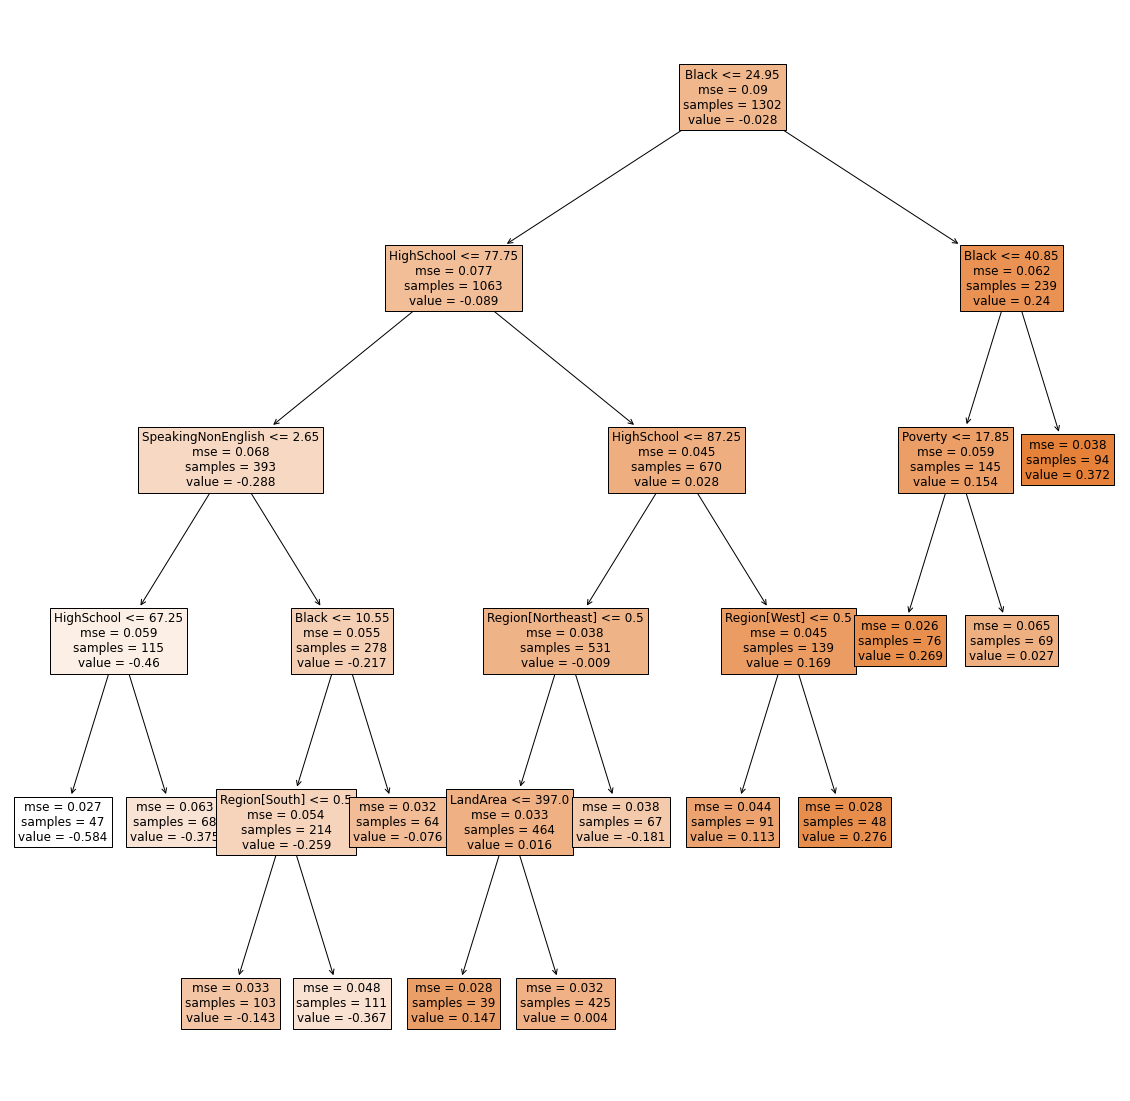

In [87]:
plt.figure(figsize=(20,20))
plot_tree(dt_tuned, feature_names=X_tree.columns, filled=True, fontsize=12)
plt.show()

That plot is easier to read. What insights can you draw from it?

In [88]:
dt_tuned_pred = dt_tuned.predict(X_validation_tree)

In [89]:
accuracy(dt_tuned_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.204271,0.162485,0.195355


It also does a little better on the validation data. We can also check feature importances:

In [90]:
get_tree_importances(dt_tuned, X_tree)

,Importance
HighSchool,0.431118
Black,0.371835
SpeakingNonEnglish,0.070540
Region[South],0.039214
Region[Northeast],0.033223
Poverty,0.031053
Region[West],0.012327
LandArea,0.010690
Region[Midwest],0.000000
PopDensity,0.000000


Compare the accuracy on the validation set of all five models fit above.

In [91]:
print("lm_1 accuracy:")
accuracy(lm_1_pred, elect_df_validation["Obama_margin_percent"])
print("gs_lasso accuracy:")
accuracy(gs_lasso_pred, elect_df_validation["Obama_margin_percent"])
print("gs_ridge accuracy:")
accuracy(gs_ridge_pred, elect_df_validation["Obama_margin_percent"])
print("dt accuracy:")
accuracy(dt_pred, elect_df_validation["Obama_margin_percent"])
print("dt_tuned accuracy:")
accuracy(dt_tuned_pred, elect_df_validation["Obama_margin_percent"])

lm_1 accuracy:


RMSE,MAE,R^2
0.189380,0.144705,0.404971


gs_lasso accuracy:


RMSE,MAE,R^2
0.169306,0.127108,0.573883


gs_ridge accuracy:


RMSE,MAE,R^2
0.169032,0.126408,0.582412


dt accuracy:


RMSE,MAE,R^2
0.224863,0.168529,0.475633


dt_tuned accuracy:


RMSE,MAE,R^2
0.204271,0.162485,0.195355


# Competition submission (for the second day on this case)

Now you will need to use your best model to predict on the test set. To do this, you will need to take the following steps:
1. Decide on which model, which parameters for the model, and what data to train the model based on your analysis above.
2. Go back and fit your model on the entire `elect_df_train` dataframe (not just the `elect_df_smaller_train` dataframe).
3. Transform your `elect_df_test` dataframe in the same way that you did the `elect_df_train` dataframe.
4. Predict on your transformed `elect_df_test` dataframe using the `predict()` method of your chosen model.
5. Save the predictions in a variable called `bm_all_fit_pred` (it should have 1131 rows and 1 column).
6. Run the code below to generate your submission csv (change `TeamX` to your team).

A useful guiding principle when coming up with your final prediction is that you should copy your code above (maybe even to a new notebook) and everywhere you see `smaller_train` replace it with `train` and everywhere you see `validation` replace it with `test`. This will include potentially redoing imputation and feature engineering steps as well. You should not be doing any _model selection_ during this process, but just _refitting_ the model you selected with the full training data set and then predicting on the testing set (just like you predicted on the validation set). However, you will not be able to test your model's accuracy using the `accuracy` function because you do not have the realizations for the test set.

The below code will combine the row numbers from the original `elect_df_test` dataset and the predictions from `bm_all_fit_pred` into a new dataframe called `submission_df`. NOTE: Until you have a variable called `bm_all_fit_pred` with your predictions in it, you will receive an error.

In [29]:
submission_df = pd.DataFrame(bm_all_fit_pred, index=elect_df_test.index, columns=['Obama_margin_percent'])

You now should have a dataframe that has indices equal to the indices for `elect_df_test` going from `1737` to `2867` and a column titled `Obama_margin_percent`. Check to make sure this is the case:

In [30]:
submission_df

,Obama_margin_percent
1737,0.100000
1738,-0.129354
1739,-0.147410
1740,0.471711
1741,-0.233333
...,...
2863,0.022727
2864,0.010601
2865,-0.094371
2866,-0.167206


 This can then be written to a submission file that is in the correct format for uploading to Kaggle.

In [ ]:
submission_df.to_csv("ObamaSubmissionTeamX.csv", index_label='Row')

# Sample Code for Getting Final Predictions

Below is sample code (not intended to be used for your actual submission) walking you through the above steps for the case where we choose the untuned decision tree. Note that the major difference is that we are using the entire training data set to create our design matrices (and not just `elect_df_smaller_train`). Then we are predicting on the test set. We cannot check our accuracy on the test set because we don't have the realizations yet.

However, before we can even train our model, we need to make sure that we re-impute using an imputer trained on the full training set (remember before we just trained the imputer on `elect_df_smaller_train`). So, we create a new imputer:

In [17]:
final_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [18]:
final_imputer.fit(elect_df_train.loc[:, "MalesPer100Females":"FarmArea"])

SimpleImputer()

Once we have `fit` the imputer (note that we fit all of the numeric rows at once, we don't need an imputer per column), we can then _transform_ the data.

In [19]:
elect_df_train.loc[:, "MalesPer100Females":"FarmArea"] = final_imputer.transform(elect_df_train.loc[:, "MalesPer100Females":"FarmArea"])

We can also impute on our testing data set as well using our `final_imputer`.

In [20]:
elect_df_test.loc[:, "MalesPer100Females":"FarmArea"] = final_imputer.transform(elect_df_test.loc[:, "MalesPer100Females":"FarmArea"])

Now we can build our final model following the same steps that we did above (note that if you are choosing a different model or you used different variables, this process will be slightly different).

In [21]:
y_tree_final, X_tree_final = dmatrices('Obama_margin_percent ~ Region + Black + HighSchool + Poverty + PopDensity + SpeakingNonEnglish + LandArea', elect_df_train, return_type="dataframe")

In [22]:
y_tree_final, X_tree_final = dmatrices('Obama_margin_percent ~ Region + Black + HighSchool + Poverty + PopDensity + SpeakingNonEnglish + LandArea', elect_df_train, return_type="dataframe")
dt = DecisionTreeRegressor()
dt.fit(X_tree_final,y_tree_final)
X_tree_test = build_design_matrices([X_tree_final.design_info], elect_df_test, return_type="dataframe")[0]
bm_all_fit_pred = dt.predict(X_tree_test)
bm_all_fit_pred.shape

DecisionTreeRegressor()

Now that we have our model built and our data transformed, we can make our final predictions and save them in `bm_all_fit_pred`.

(1131,)

In [27]:
bm_all_fit_pred

array([ 0.1       , -0.12935412, -0.14740965, ..., -0.09437086,
       -0.16720648,  0.2375    ])

In [28]:
type(bm_all_fit_pred)

numpy.ndarray

We can see that our data is in the right shape.